In [14]:
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import VECM
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

In [4]:

tickers = ['SPY','QQQ','XLK']
start="2015-01-01"
df = yf.download(tickers, start=start, auto_adjust=True, progress=False, threads=False)[['Close']]
df.dropna(inplace=True)

In [5]:
df.columns = df.columns.get_level_values(1)

In [6]:
# Johansen test function
def johansen_test(data, det_order, k_ar_diff=2):
    """
    Performs the Johansen cointegration test and prints the results.

    Parameters:
    data (numpy.ndarray): The time series data for the cointegration test.
    det_order (int): The order of the deterministic terms.
                     -1: No constant or trend.
                      0: Constant term only.
                      1: Constant and trend terms.
    k_ar_diff (int): The number of lags to include in the VAR model.

    Returns:
    result: The JohansenTestResult object containing test statistics and critical values.
    """
    try:
        result = coint_johansen(data, det_order, k_ar_diff)

        print(f'Johansen Test Results (det_order={det_order})')
        print('Trace Statistics:', result.lr1)
        print('Max Eigenvalue Statistics:', result.lr2)
        print('Critical Values (Trace):', result.cvt)
        print('Critical Values (Max Eigenvalue):', result.cvm)
        print('\n')  # Adds a space between results
        return result
    except Exception as e:
        print(f'An error occurred during the Johansen test: {e}')
        return None



In [7]:
# Running the test for different deterministic term orders
for det_order in [-1, 0, 1]:
    johansen_test(df, det_order)

Johansen Test Results (det_order=-1)
Trace Statistics: [11.15385007  5.85049701  1.99413769]
Max Eigenvalue Statistics: [5.30335307 3.85635931 1.99413769]
Critical Values (Trace): [[21.7781 24.2761 29.5147]
 [10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]]
Critical Values (Max Eigenvalue): [[15.7175 17.7961 22.2519]
 [ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]]


Johansen Test Results (det_order=0)
Trace Statistics: [22.55387953  4.68841141  0.05846133]
Max Eigenvalue Statistics: [17.86546812  4.62995008  0.05846133]
Critical Values (Trace): [[27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Critical Values (Max Eigenvalue): [[18.8928 21.1314 25.865 ]
 [12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


Johansen Test Results (det_order=1)
Trace Statistics: [34.92919969 17.32772045  4.33494547]
Max Eigenvalue Statistics: [17.60147924 12.99277497  4.33494547]
Critical Values (Trace): [[32.0645 35.0116 41.0815]
 [16.1619 18.3985 23.1485]
 [

For det = 1 and r = 2, there seem to be little cointegration.
So we will build vecm and test further

In [8]:
model = VECM(df, k_ar_diff=2, coint_rank=1, deterministic='co')  # 'ci' for constant in cointegration eq
vecm_res = model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [9]:
vecm_res.beta     # cointegration vector

array([[ 1.        ],
       [-8.51845252],
       [15.60589203]])

In [10]:
vecm_res.alpha    # adjustment speeds

array([[0.00144072],
       [0.00212149],
       [0.00051396]])

In [11]:
spread = df @ vecm_res.beta[:, 0]

In [12]:

adf_result = adfuller(spread)

In [13]:

# Print results
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"  {key}: {value}")

ADF Statistic: -3.425738959303033
p-value: 0.010112108041040669
Critical Values:
  1%: -3.432856986061305
  5%: -2.8626475938238967
  10%: -2.5673596115790938


In [17]:
def compute_rolling_johansen_trace(log_data, window_size=252, step_size=10):
    trace_stats = []

    for start in range(0, len(log_data) - window_size, step_size):
        window = log_data.iloc[start:start + window_size]
        try:
            johansen_result = coint_johansen(window, det_order=1, k_ar_diff=2)
            trace_stats.append(johansen_result.lr1)
        except Exception:
            trace_stats.append([np.nan] * len(log_data.columns))

    trace_df = pd.DataFrame(trace_stats, columns=[f"r={i}" for i in range(len(log_data.columns))])
    trace_df.index = log_data.index[window_size::step_size][:len(trace_df)]
    return trace_df

def plot_trace_stats(trace_df, title="Rolling Johansen Trace Statistics (252-day windows)"):
    plt.figure(figsize=(12, 6))
    for col in trace_df.columns:
        plt.plot(trace_df.index, trace_df[col], label=col)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Trace Statistic")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

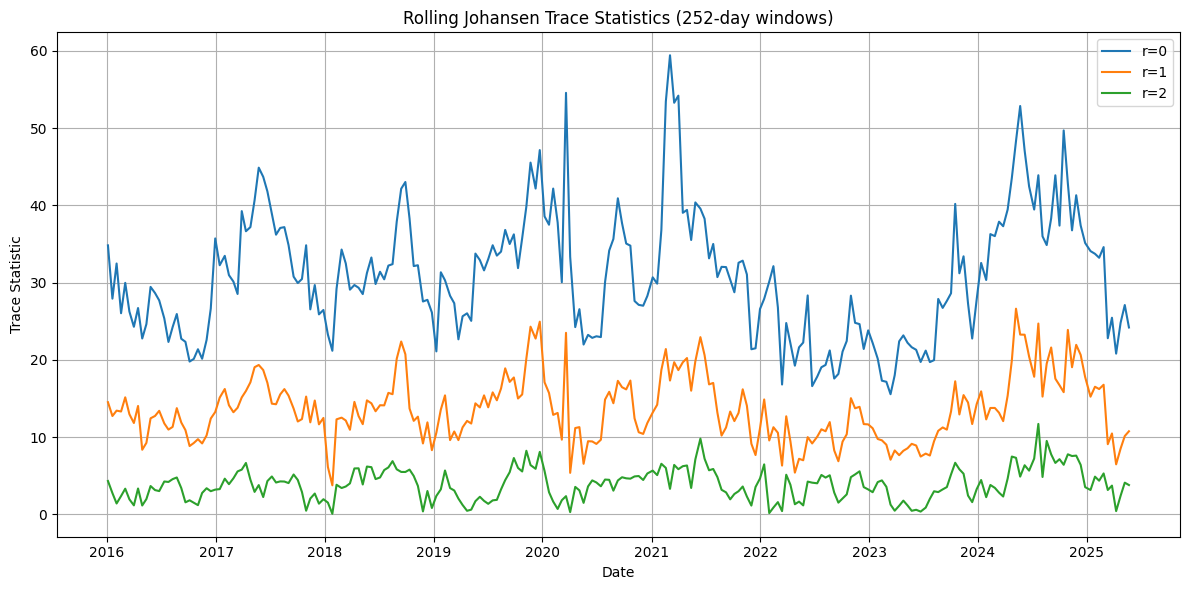

In [18]:
log_data = np.log(df)

# Step 2: Compute rolling Johansen trace stats
trace_df = compute_rolling_johansen_trace(log_data)

# Step 3: Plot
plot_trace_stats(trace_df)